In [ ]:
# scratch model
# transfer learning 1
# transfer learning 2

In [18]:
!pip install split-folders

In [19]:
import os 
import logging
import optuna

import tensorflow
import matplotlib.pyplot as plt 

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



print(tensorflow.__version__)

2.18.0


In [12]:
import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/kaggle/input/image-dataset/data", output="/kaggle/working/main",seed=1337, ratio=(.7, .2, .1))

Copying files: 5194 files [00:21, 245.13 files/s]


In [8]:
# import shutil
# shutil.make_archive('OUTPUT_NAME', 'zip', "/kaggle/working/main")


'/kaggle/working/OUTPUT_NAME.zip'

In [20]:
# creating a pipeline to generate the data : data generator

train = keras.utils.image_dataset_from_directory(
    "/kaggle/working/main/train",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=True,
)
val = keras.utils.image_dataset_from_directory(
    "/kaggle/working/main/val",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=True,
)
test = keras.utils.image_dataset_from_directory(
    "/kaggle/working/main/test",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=True,
)

Found 3635 files belonging to 5 classes.
Found 1038 files belonging to 5 classes.
Found 521 files belonging to 5 classes.


# vgg16 with optuna 

In [21]:
optuna.logging.get_logger('optuna').addHandler(logging.StreamHandler())

In [22]:
train = train.map(lambda x, y: (x / 255.0, y)).cache().shuffle(1000).prefetch(tensorflow.data.AUTOTUNE)
val = val.map(lambda x, y: (x / 255.0, y)).cache().prefetch(tensorflow.data.AUTOTUNE)


In [23]:
import os
import optuna
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def objective(trial):
    # --- Hyperparameter Suggestions ---
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "parametric relu"])
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_units = trial.suggest_categorical("n_units", [64, 128, 256, 512])
    optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd", "adagrad"])

    # --- Base Pretrained Model ---
    base_model = keras.applications.ResNet50(
        include_top=False, weights='imagenet', input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    # --- Build the Model ---
    model = Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())

    for _ in range(n_layers):
        model.add(layers.Dense(n_units))
        if activation == "parametric relu":
            model.add(layers.PReLU())
        else:
            model.add(layers.Activation(activation))
        model.add(layers.Dropout(0.5))

    model.add(layers.Dense(17, activation="softmax"))

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # --- Checkpoint and EarlyStopping ---
    os.makedirs("resnet_checkpoints", exist_ok=True)
    checkpoint_path = f"resnet_checkpoints/resnet_trial_{trial.number}.keras"

    callbacks = [
        ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=False,
            mode="min",
            verbose=0
        ),
        EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True,
            verbose=0
        )
    ]

    # --- Model Training ---
    history = model.fit(
        train,
        validation_data=val,
        epochs=50,
        batch_size=256,
        callbacks=callbacks,
        verbose=1
    )

    # --- Logging for Optuna ---
    val_loss = history.history["val_loss"][-1]
    trial.set_user_attr("val_accuracy", history.history.get("val_accuracy", [None])[-1])
    trial.set_user_attr("history", history.history)

    return val_loss


In [24]:


# Logging and study setup
optuna.logging.get_logger("optuna").addHandler(logging.FileHandler("optuna_resnet50.log"))

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.RandomSampler(),
    study_name="resnet_tuning"
)

study.optimize(objective, n_trials=5,show_progress_bar=True)

A new study created in memory with name: resnet_tuning
[I 2025-06-26 12:45:42,998] A new study created in memory with name: resnet_tuning
A new study created in memory with name: resnet_tuning
A new study created in memory with name: resnet_tuning


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - accuracy: 0.1952 - loss: 2.3359 - val_accuracy: 0.2312 - val_loss: 1.7005
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.2017 - loss: 1.8297 - val_accuracy: 0.2303 - val_loss: 1.6541
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.1989 - loss: 1.7652 - val_accuracy: 0.2312 - val_loss: 1.6334
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.2081 - loss: 1.7175 - val_accuracy: 0.2312 - val_loss: 1.6259
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.2166 - loss: 1.6753 - val_accuracy: 0.2312 - val_loss: 1.6041
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.2251 - loss: 1.6568 - val_accuracy: 0.2312 - val_loss: 1.6090
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.2321 - loss: 1.6464 - val_accuracy: 0.2293 - val_loss: 1.6022
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.2273 - loss: 1.6404 - val_ac

Trial 0 finished with value: 1.5933629274368286 and parameters: {'activation': 'parametric relu', 'n_layers': 3, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 0 with value: 1.5933629274368286.
Trial 0 finished with value: 1.5933629274368286 and parameters: {'activation': 'parametric relu', 'n_layers': 3, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 0 with value: 1.5933629274368286.
Trial 0 finished with value: 1.5933629274368286 and parameters: {'activation': 'parametric relu', 'n_layers': 3, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 0 with value: 1.5933629274368286.


[I 2025-06-26 12:50:24,227] Trial 0 finished with value: 1.5933629274368286 and parameters: {'activation': 'parametric relu', 'n_layers': 3, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 0 with value: 1.5933629274368286.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - accuracy: 0.2004 - loss: 2.1596 - val_accuracy: 0.2312 - val_loss: 1.6731
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.2005 - loss: 1.7896 - val_accuracy: 0.2293 - val_loss: 1.6215
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.2173 - loss: 1.7208 - val_accuracy: 0.2312 - val_loss: 1.6062
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.2074 - loss: 1.6936 - val_accuracy: 0.2312 - val_loss: 1.6051
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.2156 - loss: 1.6712 - val_accuracy: 0.2312 - val_loss: 1.6039
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.2266 - loss: 1.6468 - val_accuracy: 0.2312 - val_loss: 1.622

Trial 1 finished with value: 1.5931649208068848 and parameters: {'activation': 'relu', 'n_layers': 2, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 1 with value: 1.5931649208068848.
Trial 1 finished with value: 1.5931649208068848 and parameters: {'activation': 'relu', 'n_layers': 2, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 1 with value: 1.5931649208068848.
Trial 1 finished with value: 1.5931649208068848 and parameters: {'activation': 'relu', 'n_layers': 2, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 1 with value: 1.5931649208068848.


[I 2025-06-26 12:53:50,693] Trial 1 finished with value: 1.5931649208068848 and parameters: {'activation': 'relu', 'n_layers': 2, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 1 with value: 1.5931649208068848.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - accuracy: 0.2171 - loss: 1.9868 - val_accuracy: 0.2312 - val_loss: 1.6260
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.2410 - loss: 1.6591 - val_accuracy: 0.2293 - val_loss: 1.6056
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.2190 - loss: 1.6409 - val_accuracy: 0.2312 - val_loss: 1.6162
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.2254 - loss: 1.6246 - val_accuracy: 0.2312 - val_loss: 1.6025
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.2278 - loss: 1.6196 - val_accuracy: 0.2293 - val_loss: 1.5956
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.2394 - loss: 1.6213 - val_accuracy: 0.2312 - val_loss: 1.5947
Epoch 7/5

Trial 2 finished with value: 1.5962584018707275 and parameters: {'activation': 'relu', 'n_layers': 1, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 1 with value: 1.5931649208068848.
Trial 2 finished with value: 1.5962584018707275 and parameters: {'activation': 'relu', 'n_layers': 1, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 1 with value: 1.5931649208068848.
Trial 2 finished with value: 1.5962584018707275 and parameters: {'activation': 'relu', 'n_layers': 1, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 1 with value: 1.5931649208068848.


[I 2025-06-26 12:56:51,960] Trial 2 finished with value: 1.5962584018707275 and parameters: {'activation': 'relu', 'n_layers': 1, 'n_units': 256, 'optimizer': 'sgd'}. Best is trial 1 with value: 1.5931649208068848.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - accuracy: 0.1582 - loss: 2.5073 - val_accuracy: 0.2312 - val_loss: 1.8038
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.2077 - loss: 1.8482 - val_accuracy: 0.2293 - val_loss: 1.6850
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.2233 - loss: 1.7319 - val_accuracy: 0.2293 - val_loss: 1.6122
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.2176 - loss: 1.6848 - val_accuracy: 0.2312 - val_loss: 1.6136
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.2150 - loss: 1.6579 - val_accuracy: 0.2312 - val_loss: 1.6008
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.2311 - loss: 1.6314 - val_accuracy: 0.2312 - val_loss: 1.5963
Epoch 7/5

Trial 3 finished with value: 1.592504858970642 and parameters: {'activation': 'relu', 'n_layers': 3, 'n_units': 64, 'optimizer': 'adam'}. Best is trial 3 with value: 1.592504858970642.
Trial 3 finished with value: 1.592504858970642 and parameters: {'activation': 'relu', 'n_layers': 3, 'n_units': 64, 'optimizer': 'adam'}. Best is trial 3 with value: 1.592504858970642.
Trial 3 finished with value: 1.592504858970642 and parameters: {'activation': 'relu', 'n_layers': 3, 'n_units': 64, 'optimizer': 'adam'}. Best is trial 3 with value: 1.592504858970642.


[I 2025-06-26 12:59:49,215] Trial 3 finished with value: 1.592504858970642 and parameters: {'activation': 'relu', 'n_layers': 3, 'n_units': 64, 'optimizer': 'adam'}. Best is trial 3 with value: 1.592504858970642.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 30s 142ms/step - accuracy: 0.1607 - loss: 2.3730 - val_accuracy: 0.2312 - val_loss: 1.6340
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.2151 - loss: 1.7626 - val_accuracy: 0.2293 - val_loss: 1.6283
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.2137 - loss: 1.6925 - val_accuracy: 0.4355 - val_loss: 1.5944
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.2280 - loss: 1.6610 - val_accuracy: 0.2322 - val_loss: 1.5946
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.2258 - loss: 1.6453 - val_accuracy: 0.2399 - val_loss: 1.5939
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.2141 - loss: 1.6442 - val_accuracy: 0.2312 - val_loss: 1.5895
Epoch 7/50


Trial 4 finished with value: 1.2493939399719238 and parameters: {'activation': 'relu', 'n_layers': 2, 'n_units': 128, 'optimizer': 'adam'}. Best is trial 4 with value: 1.2493939399719238.
Trial 4 finished with value: 1.2493939399719238 and parameters: {'activation': 'relu', 'n_layers': 2, 'n_units': 128, 'optimizer': 'adam'}. Best is trial 4 with value: 1.2493939399719238.
Trial 4 finished with value: 1.2493939399719238 and parameters: {'activation': 'relu', 'n_layers': 2, 'n_units': 128, 'optimizer': 'adam'}. Best is trial 4 with value: 1.2493939399719238.


[I 2025-06-26 13:05:43,376] Trial 4 finished with value: 1.2493939399719238 and parameters: {'activation': 'relu', 'n_layers': 2, 'n_units': 128, 'optimizer': 'adam'}. Best is trial 4 with value: 1.2493939399719238.


In [19]:
import shutil
shutil.make_archive('resnet_checkpoints', 'zip', "/kaggle/working/resnet_checkpoints")


'/kaggle/working/resnet_checkpoints.zip'

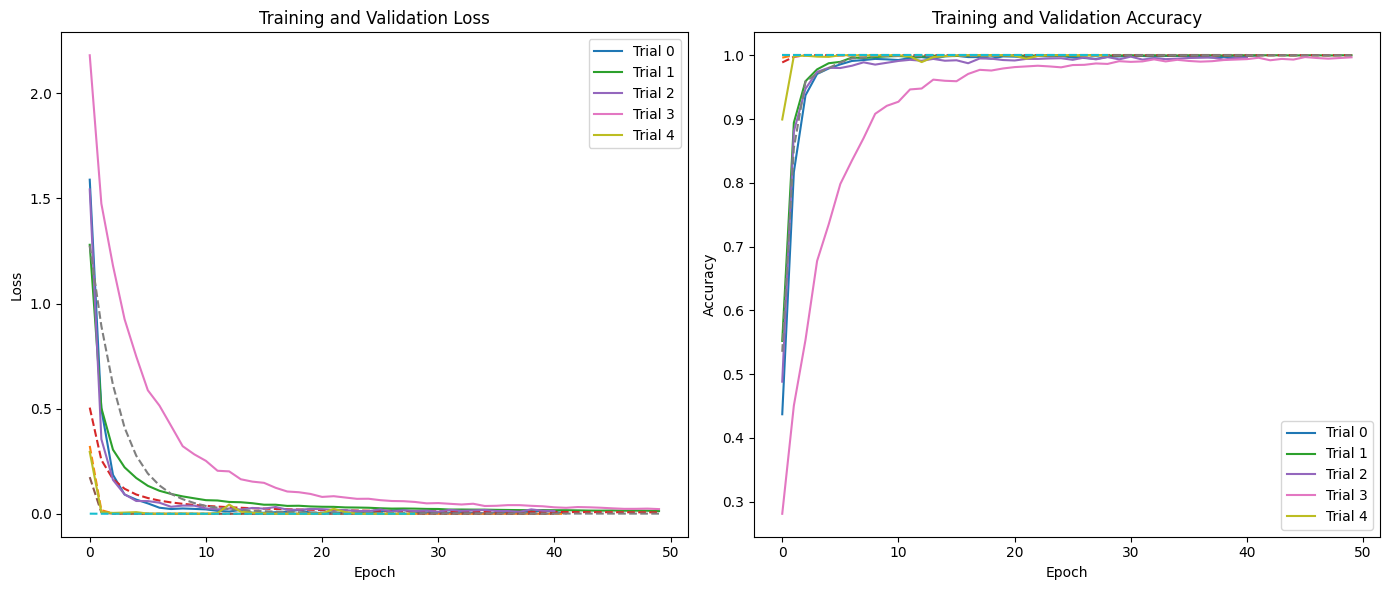

In [11]:
import matplotlib.pyplot as plt

# Create subplots for loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for trial in study.trials:
    history = trial.user_attrs.get("history")
    if history:
        axs[0].plot(history["loss"], label=f"Trial {trial.number}")
        axs[0].plot(history["val_loss"], linestyle='--')

        axs[1].plot(history["accuracy"], label=f"Trial {trial.number}")
        axs[1].plot(history["val_accuracy"], linestyle='--')

axs[0].set_title("Training and Validation Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")

axs[1].set_title("Training and Validation Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")

axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.savefig("plots/mobilenet.png")

plt.show()




In [ ]:
import shutil
shutil.make_archive('resnet_optuna_checkpoints', 'zip', "/kaggle/working/resnet_checkpoints")
